In [403]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# References


This notebook is based on the papers:
- *Independent component analysis: An introduction.* - Alaa Tharwat
- *Blind Source Separation of Underwater Acoustic Signal by Use of Negentropy-based Fast ICA Algorithm.* - Tu Shijie and Chen Hang

The notation in this notebook follows the paper of Alaa Tharwat

# Theoretical Background

Independent component Analysis (ICA) is a method for recovering the original components from a set of mixtures of signals.

An simple example of what we are trying to do is the **cocktail party problem**, where the goal is to extract the voices of single party members even though different voices in the environment are superimposed.


![alt text](<Screenshot (1927).png>)

## Formal definitions

In the following section we will proceed with illustrating the mathematical background of the ICA algorithm

We define a **mixture of signals** as:  
$$X = AS$$   

where:
- $A$ is the mixing matrix
- $S$ are the original signals
- $X$ are the mixtures


Our aim, by applying ICA, it to find the **unmixing matrix**:
$$Y = W^T X$$   

where:
- $W$ is the unmixing matrix
- $X$ are the mixtures
- $Y$ are the recovered signals

TODO

# FastICA Implementation

Function to perform 'Centering' and 'Whitening' step

In [404]:
# This function assumes as input a matrix X with samples on columns
def preprocessing(X, n_sources, under_complete = True):
    # Centering step
    X_mean = np.mean(X, axis = 1)               # Samples on columns
    X_bar = X - X_mean[:, None]
 

    # PCA Dimensionality reduction
    U, s, VT = np.linalg.svd(X_bar, full_matrices = False)

    # If the number of sources is less than the number of mixtures we perform dimensionality reduction
    # and keep only the first n_sources principal components (under-complete ICA)
    if under_complete:
        if (n_sources < X.shape[0]):
            T = U[:, :n_sources].T @ X_bar              # First 'n_sources' Principal components    
            print("Dimensionality reduction performed")
        else:
            T = U.T @ X_bar
    else:
        T = U.T @ X_bar                     


    # Scaling / Normalization step
    T_std = np.std(T, axis = 1) 
    T_norm = (T) / T_std[:, None]

    return T_norm

Fast ICA algorithm

In [405]:
# This function assumes as input a matrix X with samples on columns, automatically performs the preprocessing step
def FastIca(mixture_signals, n_sources, n_iter = 5000, tol = 1e-9, under_complete = True):
    # Preprocessing step
    X = preprocessing(mixture_signals, n_sources, under_complete = under_complete)

    # Number of mixtures
    n_mixtures = X.shape[0]
    # Number of samples
    n_samples = X.shape[1]

    # Initialize a random weight Matrix with unit varinace
    W = np.random.rand(n_mixtures, n_sources) 
    W_std = np.std(W, axis = 1) 
    W = (W) / W_std[:, None]


    # FastICA algorithm
    for p in range(n_sources):
        w_p = W[:, p]                           # recover the p-th row of W

        # Computing a single independent component
        for i in range(n_iter):                 
            w_p_old = w_p

            y = w_p.T @ X                       # Argument of g
            # Computing the fisrt derivative  
            g = y*np.exp(-y**2/2)   
            # g = np.tanh(y)       

            # Computing the second derivative
            g_prime = (1 - y**2)*np.exp(-y**2/2)
            # g_prime = 1 - np.tanh(y)**2

            # Update rule
            w_p = X @ g.T / n_samples - np.mean(g_prime)*w_p

            # Orthogonalization step
            w_p = w_p - W[:, :p] @ W[:, :p].T @ w_p

            # Method 2 for orthogonalization
            # for k in range(p):
            #      w_p = w_p - np.dot(W[:, k], w_p) * W[:, k]

            # Normalization step
            w_p = w_p / np.linalg.norm(w_p)

            # Convergence criterion
            if (np.linalg.norm(w_p - w_p_old) < tol):
                break
        
        W[:, p] = w_p
    
    # Recovering the sources
    S = W.T @ X
    return S, W     

Utils function for plotting

In [406]:
# Function to plot the signals
def plot_signals(t, S, title, labels = False, scaling = 1): 
    # Creating the figure
    plt.figure(figsize=(20, 6))

    # Plotting the signals
    if labels:
        for i in range(S.shape[0]):
            plt.plot(t, S[i], label = "s "+str(i+1), linewidth = 4)
    else:
        for i in range(S.shape[0]):
            plt.plot(t, S[i], linewidth = 4)

    plt.title(title, fontsize = 20)
    plt.xlabel("t")
    plt.ylabel("Amplitude")

    # Setting limits for the axes
    plt.xlim(0, 20)
    plt.ylim(-1*scaling, 1*scaling)

    if labels:
        plt.legend()

In [407]:
def plot_mixtures(t, X, scaling = 1):

    n_mixtures = X.shape[0]

    # Plotting the mixed signals
    fig, axs = plt.subplots(nrows=n_mixtures, ncols=1, figsize = (20, 5*n_mixtures))
    axs = axs.flatten()

    for i in range(n_mixtures):
        axs[i].plot(t, X[i], linewidth = 4)     
        axs[i].set_title('mixture '+str(i+1), fontsize = 20)
        axs[i].set_xlabel("t")
        axs[i].set_ylabel("Amplitude")


        # Setting limits for the axes
        axs[i].set_xlim(0, 30)
        axs[i].set_ylim(-1*scaling, 1*scaling)

## Example 1

In this example we try to reconstruct 3 sources from 3 mixtures


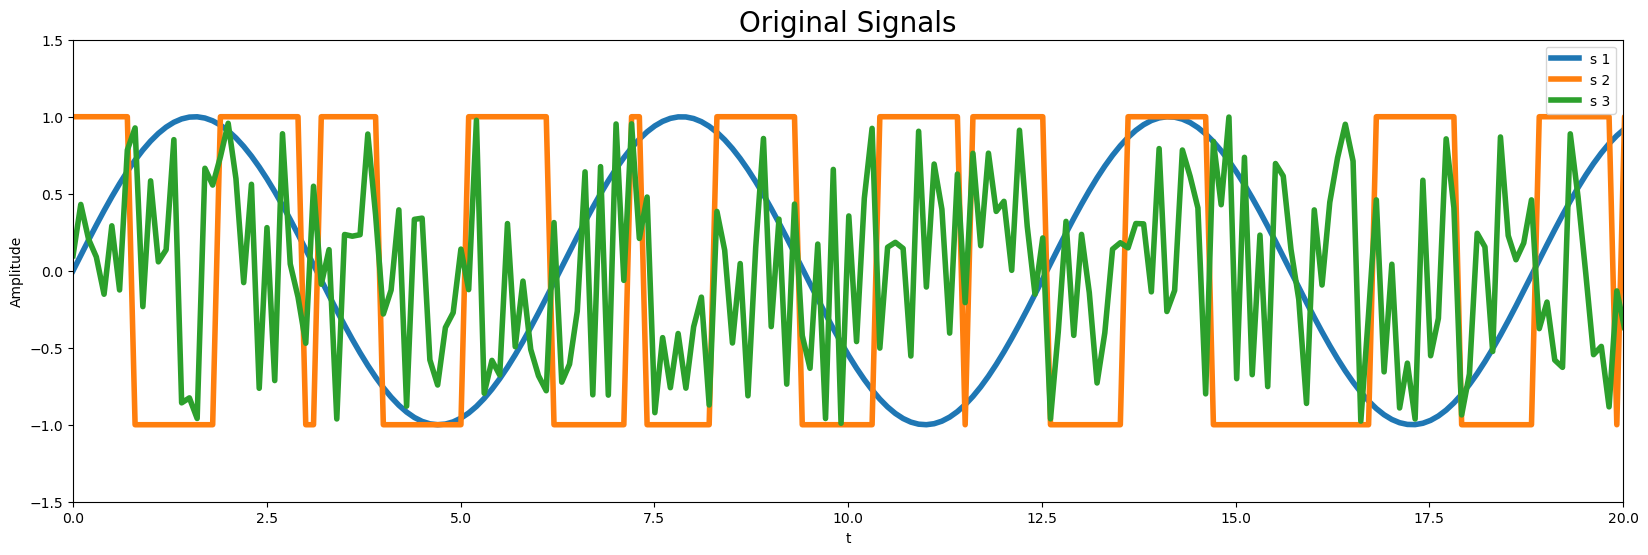

In [408]:
# Samples
n_samples = 1000
t = np.linspace(0, 100, n_samples)

# Seed for reproducibility
np.random.seed(0)

# Generate 3 signals
s1 = np.sin(t)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = np.random.uniform(-1, 1, n_samples)                # Random uniform noise

# Sources matrix
S = np.array([s1, s2, s3])


# Plotting the signals
plot_signals(t, S, "Original Signals", labels = True, scaling = 1.5)

Here we build a mixing matrix and mix the signals

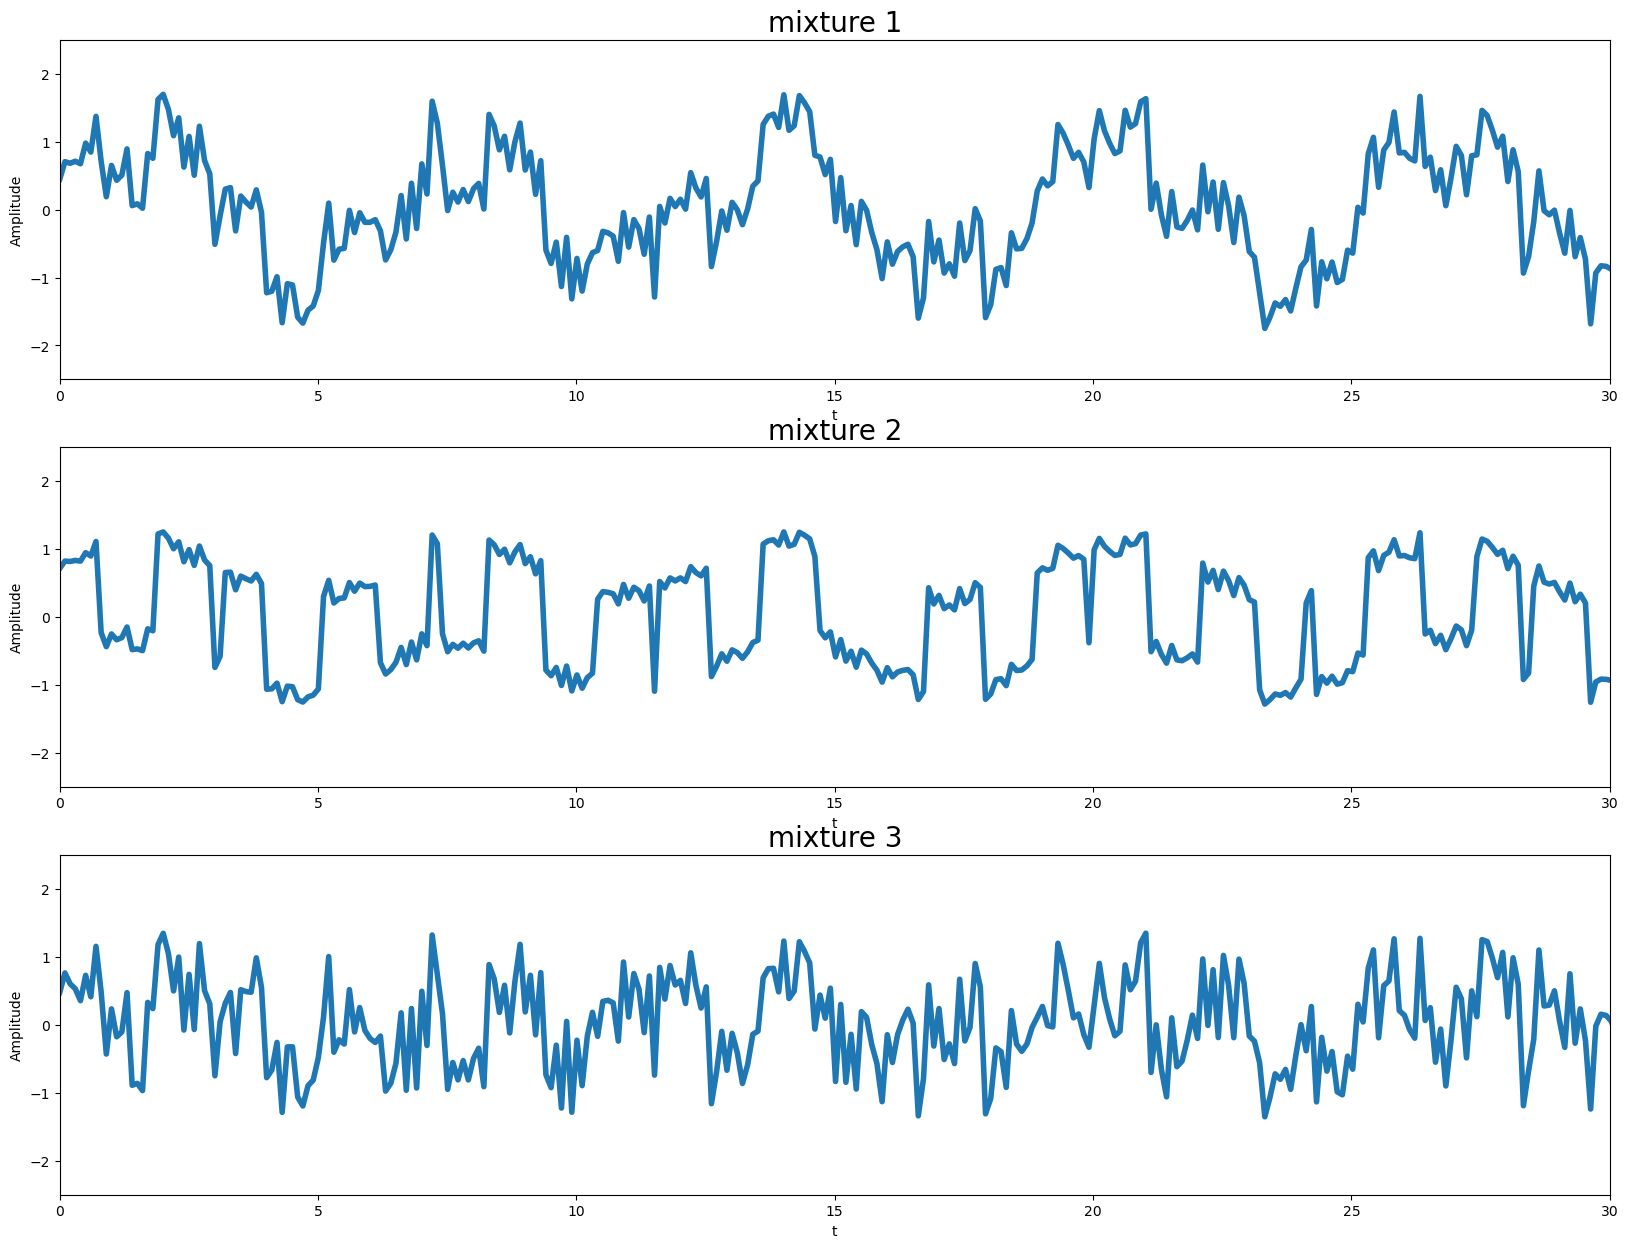

In [409]:
# # Mixing matrix
A = np.array([[0.9, 0.4, 0.5],
              [0.4, 0.7, 0.2],
              [0.2, 0.4, 0.8]])


# Mixed signals
X = A @ S

# Plotting the mixed signals
plot_mixtures(t, X, scaling = 2.5)

In [410]:
# Reconstructing the signals
S_recovered, W = FastIca(X, 3)

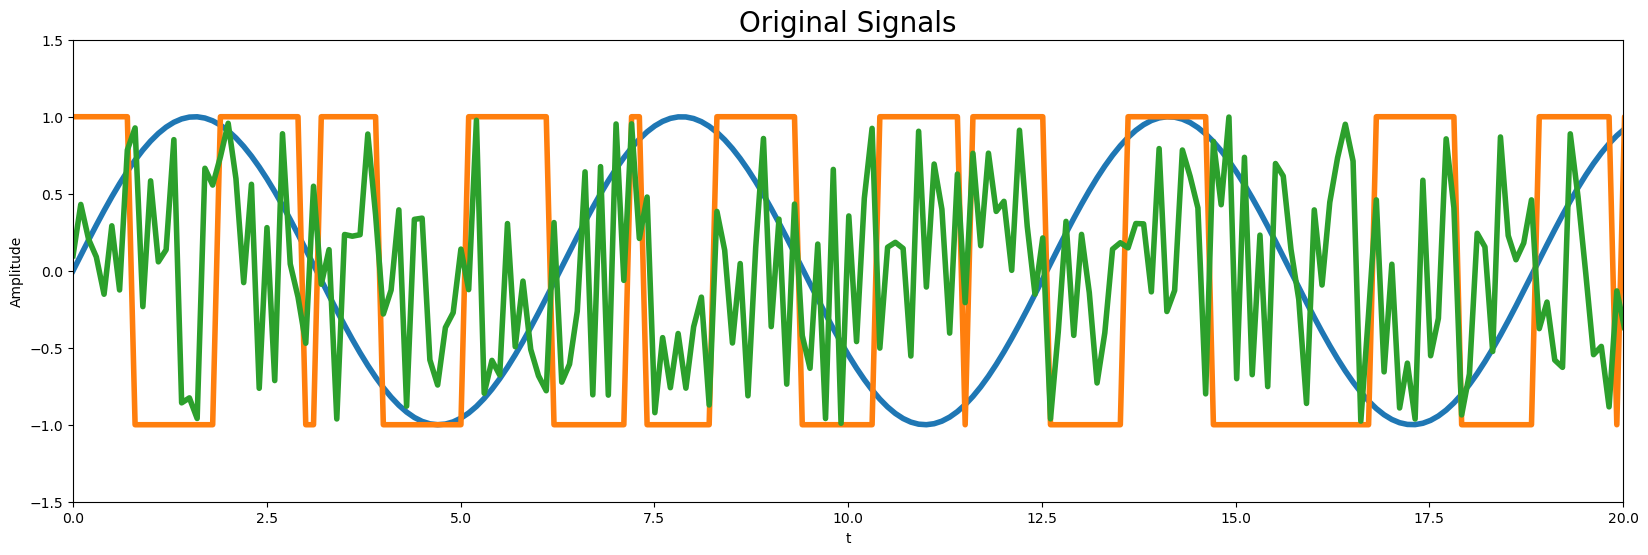

In [411]:
plot_signals(t, S, "Original Signals", labels = False, scaling = 1.5)

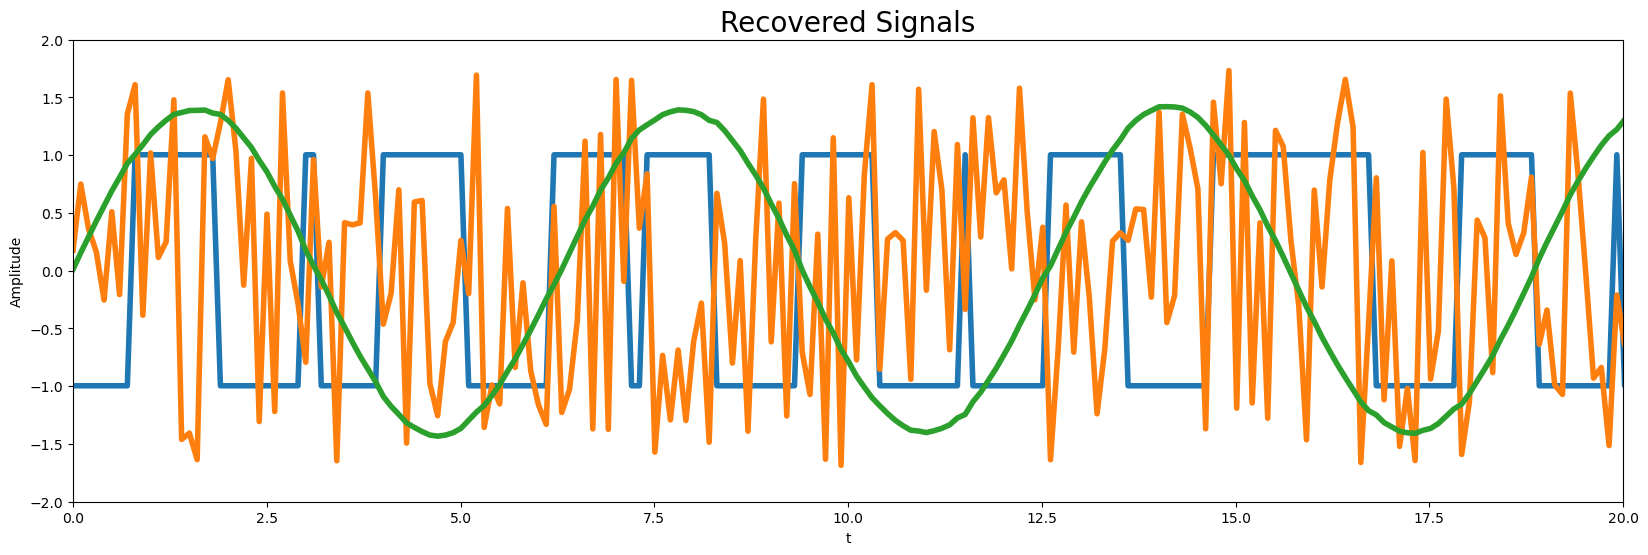

In [412]:
plot_signals(t, S_recovered, "Recovered Signals", labels = False, scaling = 2)

As we can see ICA recovers some of the original signals with swapped sign, this is becouse the sources are independent and the mixing process is linear, the same sources can be recovered with different signs or orders. This ambiguity arises because multiplying a source by -1 does not change its independence or the linear mixing process.

## Other Examples

### 4 Signals

In this example we see how the algorithm above behave when applied to a mixture of 4 signals

In [413]:
# Samples
n_samples = 10000                                      # The number of samples is increased from the 3 signals case
t = np.linspace(0, 1000, n_samples)

# Generate 4 signals
s1 = np.sin(t)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = np.cos(t*2.4)                                      # Cosine
s4 = signal.sawtooth(t*2.1).squeeze()                   # Sawtooth wave  


# Sources matrix
S = np.array([s1, s2, s3, s4])


# # Mixing matrix
A = np.array([[0.9, 0.5, 0.4, 0.6],
              [0.4, 0.7, 0.2, 0.3],
              [0.2, 0.4, 0.8, 0.5],
              [0.3, 1, 0.2, 0.9]])


# Mixed signals
X = A @ S


# FastICA
S_recovered, W = FastIca(X, 4)

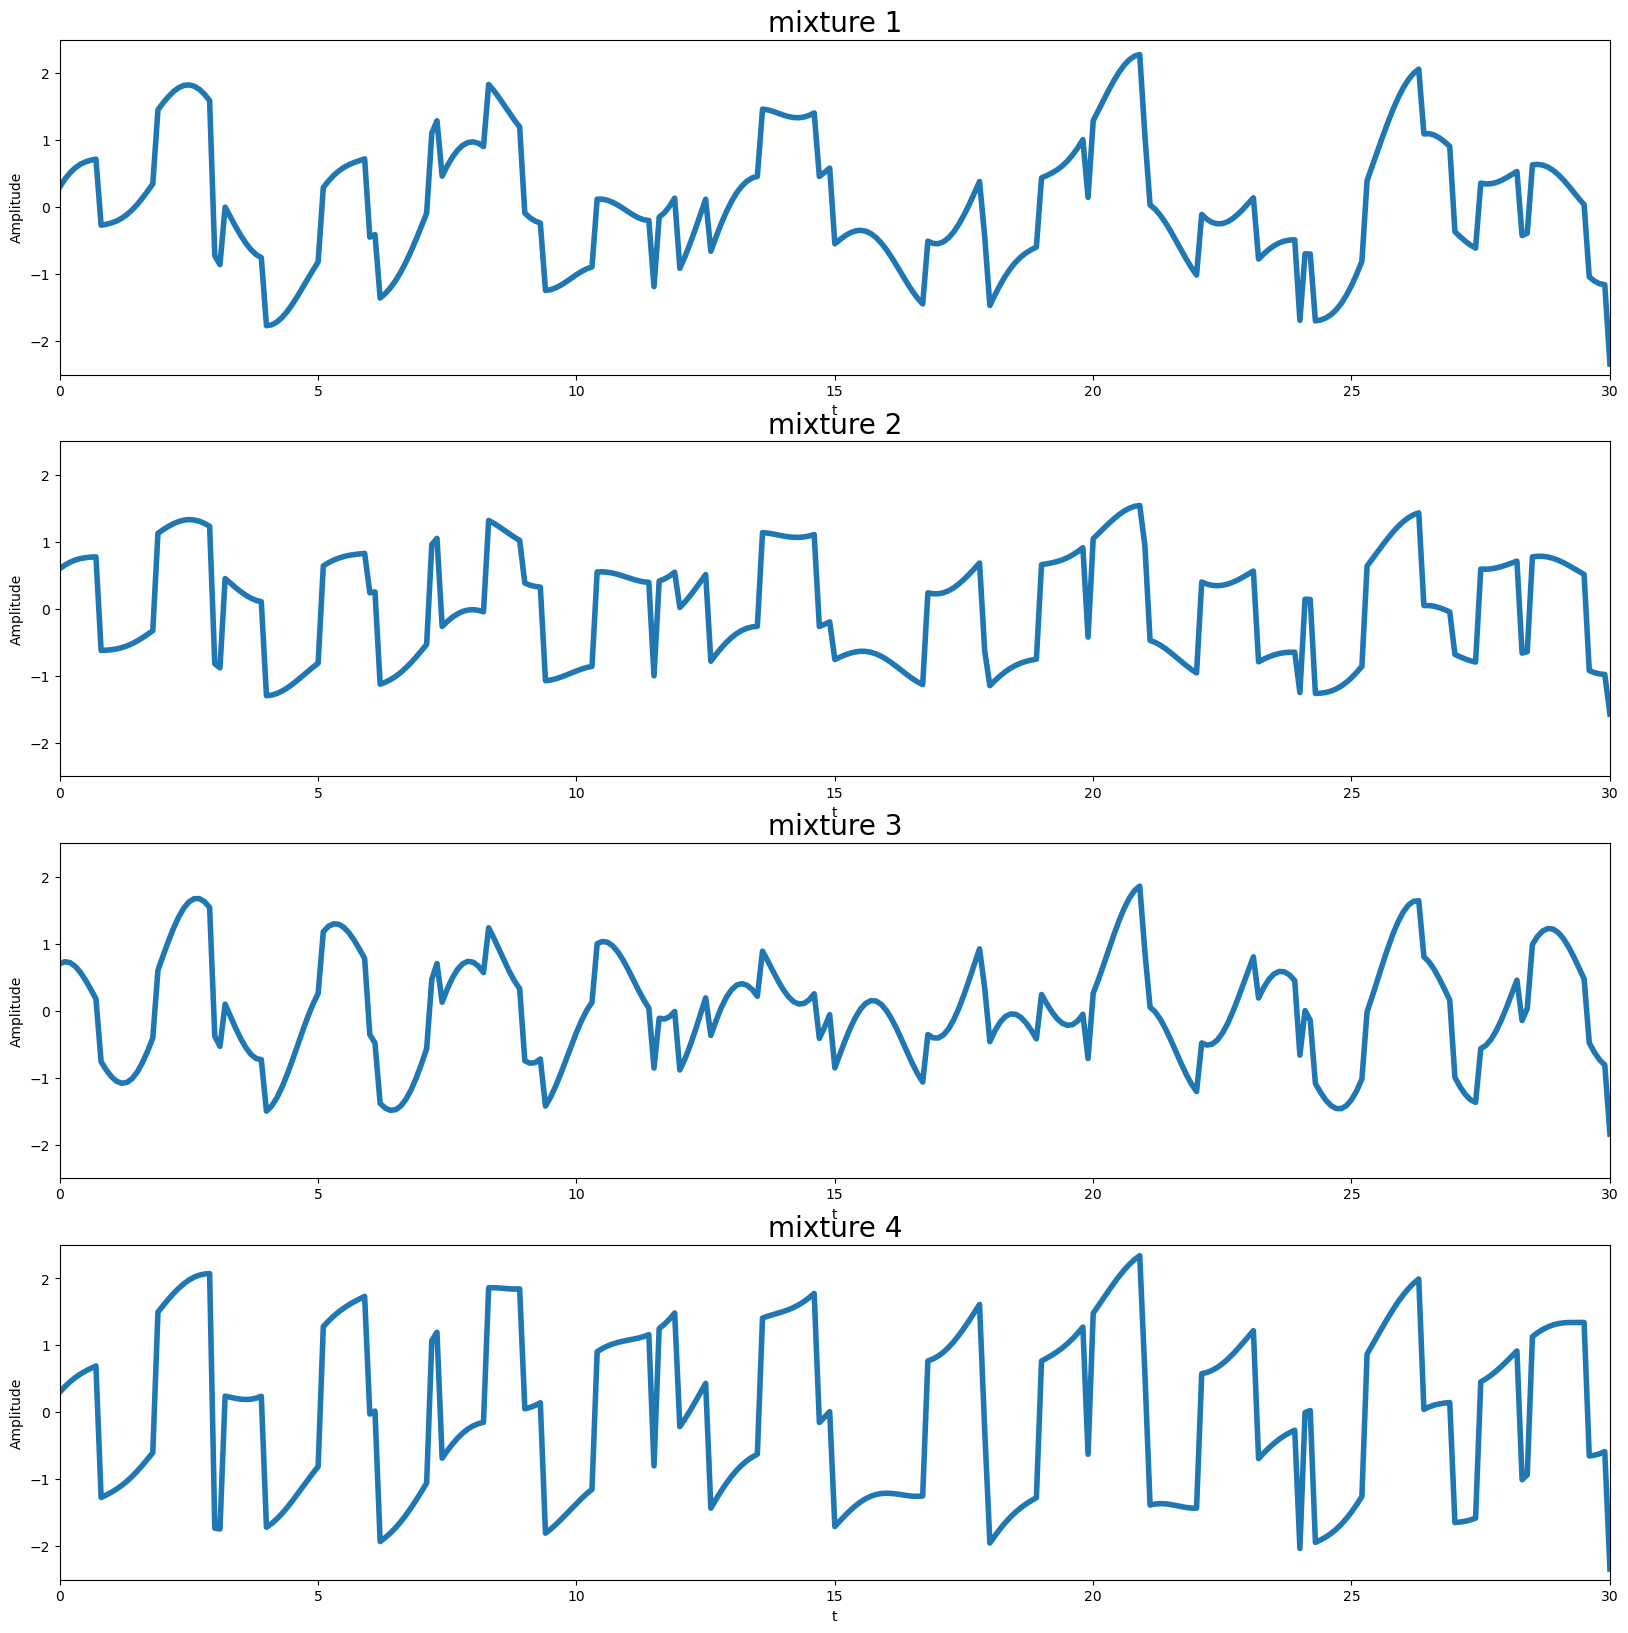

In [414]:
# Plotting the mixed signals
plot_mixtures(t, X, scaling = 2.5)

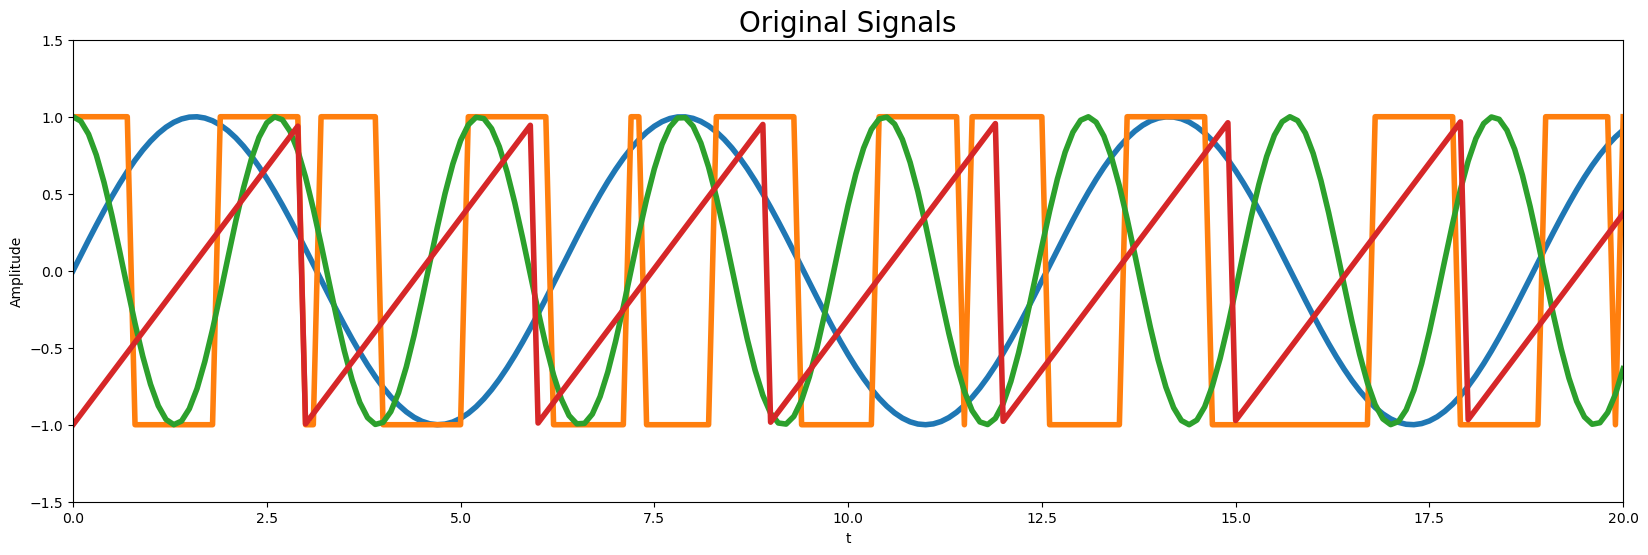

In [415]:
plot_signals(t, S, "Original Signals", labels = False, scaling = 1.5)

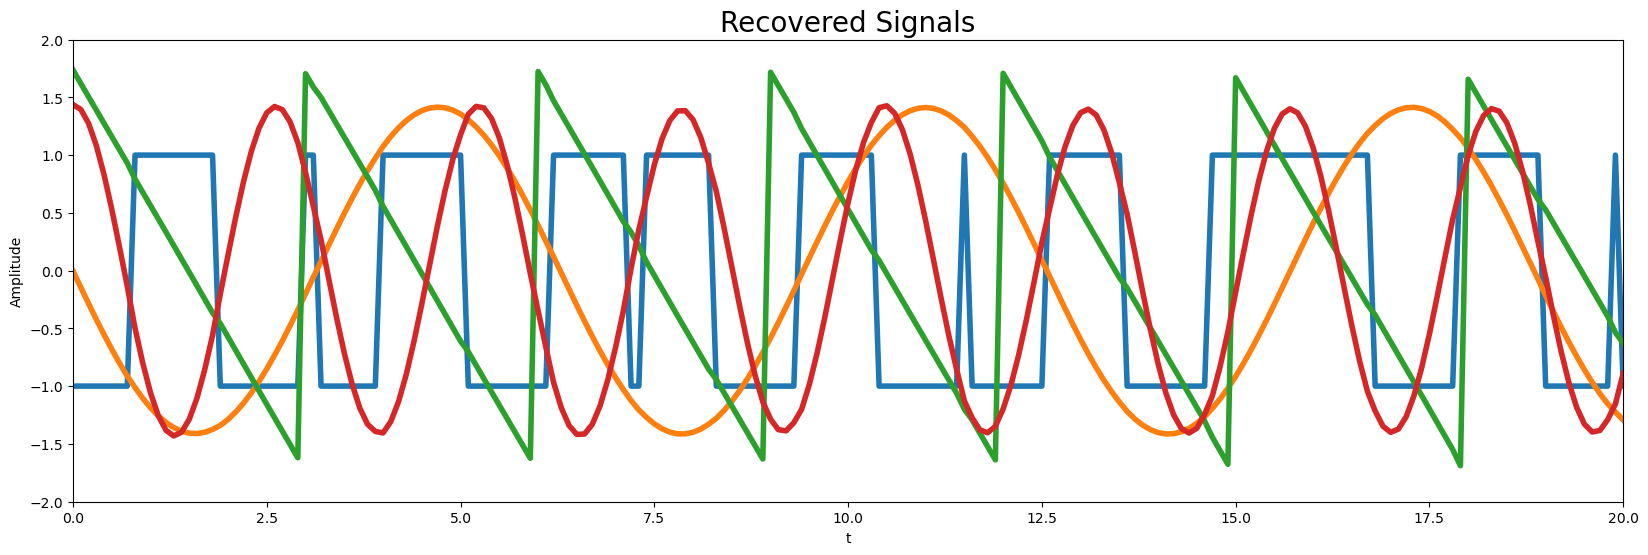

In [416]:
plot_signals(t, S_recovered, "Recovered Signals", labels = False, scaling = 2)

### Undercomplete ICA

In this example we see how dimensionality reduction affects the under complete case (i.e more mixtures then sources)

In [417]:
# Samples
n_samples = 10000
t = np.linspace(0, 1000, n_samples)

# Generate 4 signals
s1 = np.sin(t)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = signal.sawtooth(t*2.1).squeeze()                   # Sawtooth wave  


# Sources matrix
S = np.array([s1, s2, s3])


# # Mixing matrix
A = np.array([[0.9, 0.5, 0.4],
              [0.4, 0.7, 0.2],
              [0.2, 0.4, 0.8],
              [0.3, 1, 0.2]])


# Mixed signals
X = A @ S


# FastICA
S_recovered_undercomplete, W = FastIca(X, 3, under_complete = True)
S_recovered, W = FastIca(X, 3, under_complete = False)

Dimensionality reduction performed


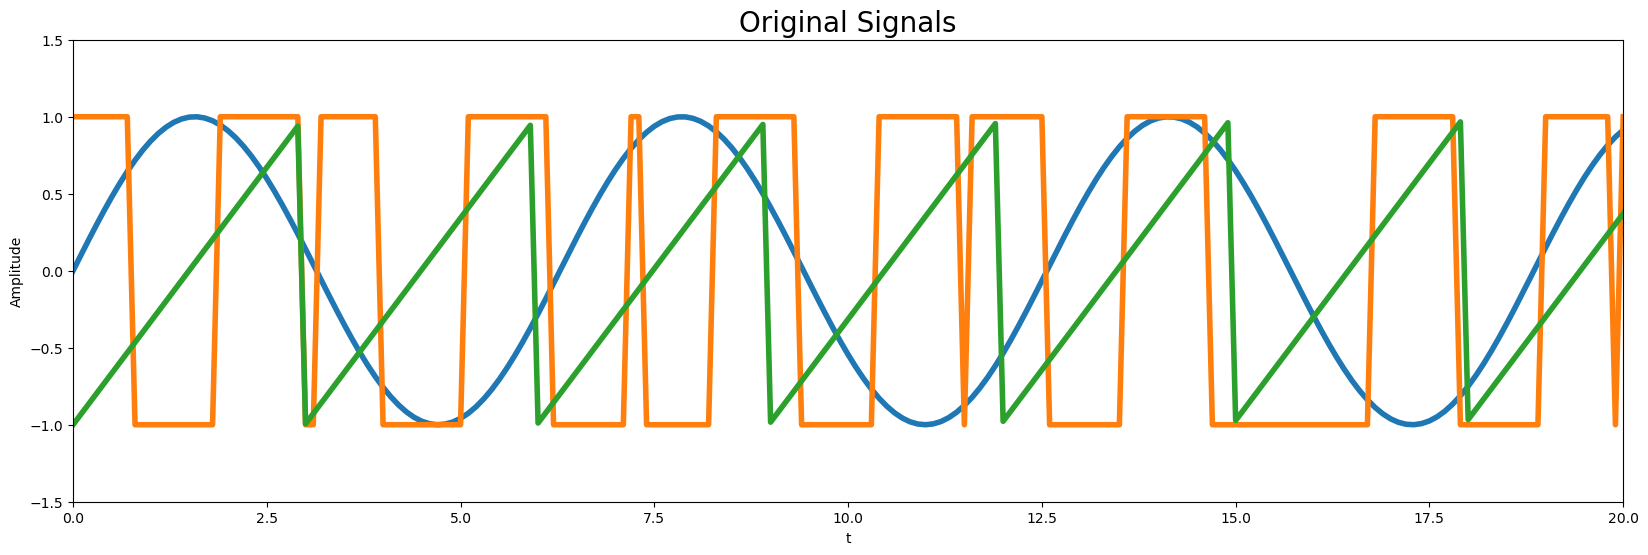

In [418]:
plot_signals(t, S, "Original Signals", labels = False, scaling = 1.5)

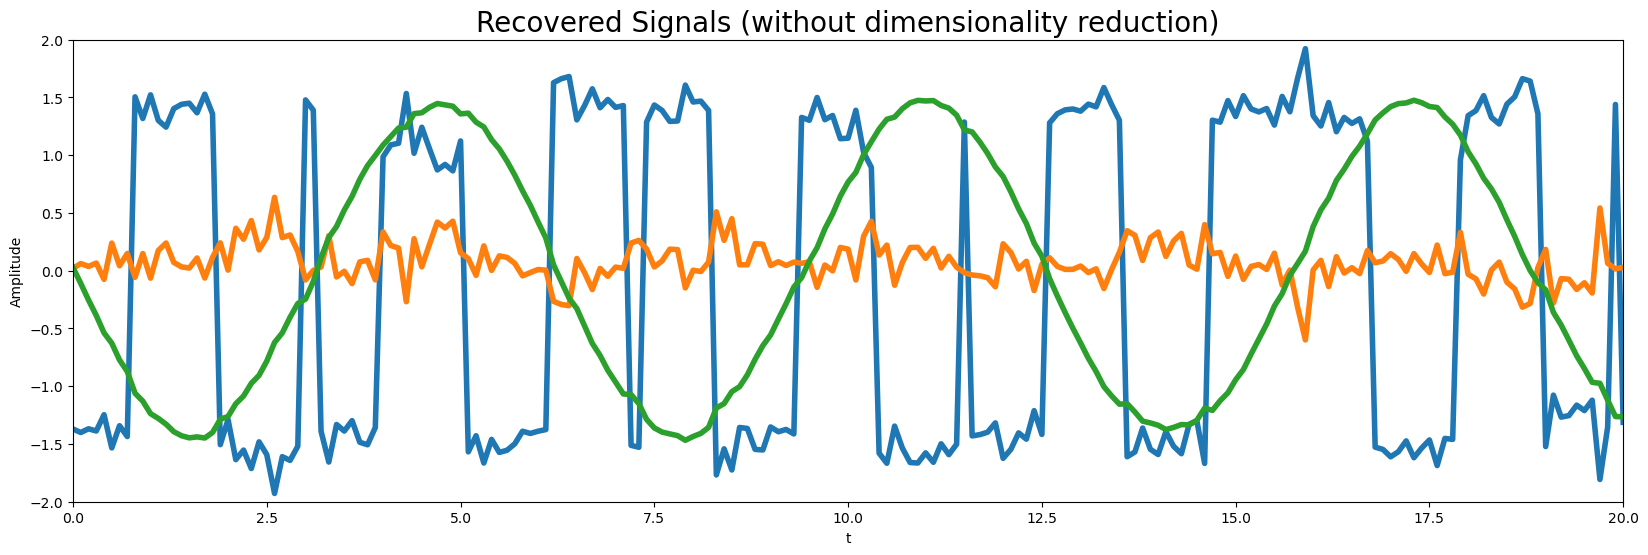

In [419]:
plot_signals(t, S_recovered, "Recovered Signals (without dimensionality reduction)", labels = False, scaling = 2)

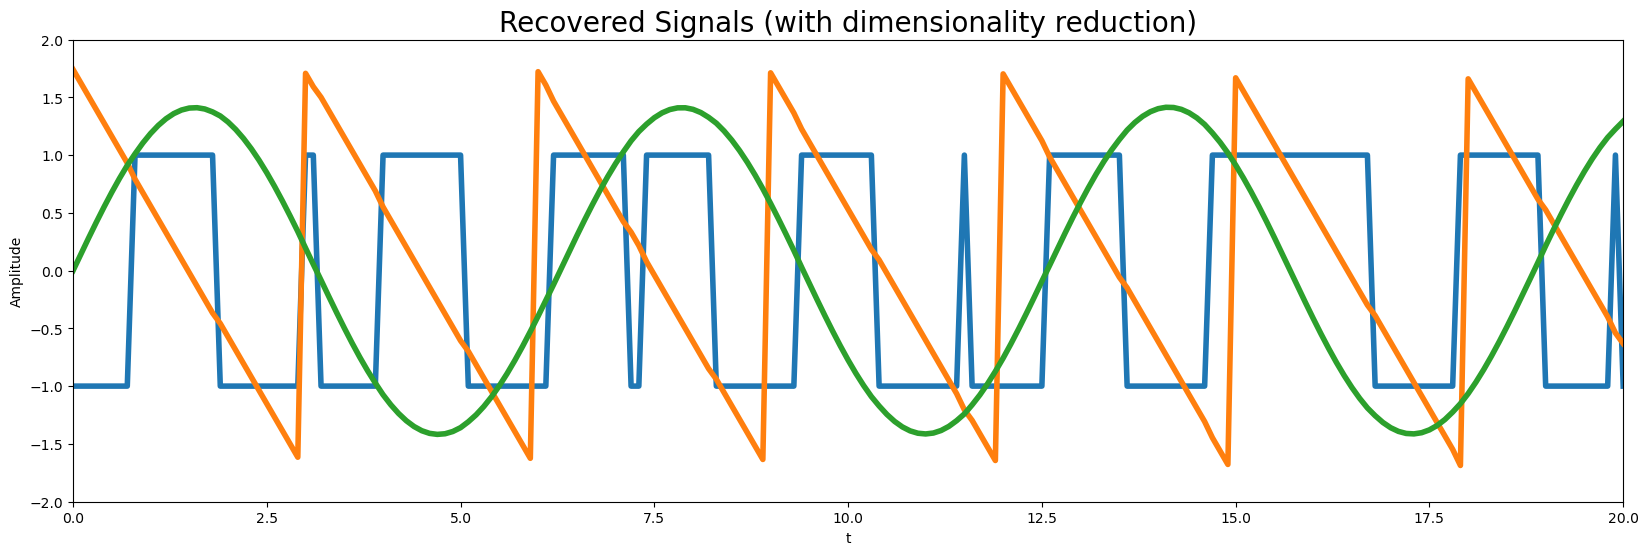

In [420]:
plot_signals(t, S_recovered_undercomplete, "Recovered Signals (with dimensionality reduction)", labels = False, scaling = 2)